### Imports

In [9]:
import tensorflow as tf

from keras import Sequential
from keras.applications import vgg16
from keras.optimizers import adam_v2
from keras.losses import sparse_categorical_crossentropy
from keras.layers import Dense, Flatten

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Constants

In [10]:
# Get train and test data from folder.
TRAIN_DIRECTORY = "data/AFD/AFD（Animal Face Dataset)/face images/Saimiri sciureus"
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32  # This is keras default
NUM_CHANNELS = 3
IMAGE_DIMENSIONS = (IMG_HEIGHT, IMG_WIDTH)
SEED = 123

NUM_EPOCHS = 20
LEARNING_RATE = 0.001

VALIDATION_SPLIT = 0.2  # 20% reserved for validation

### Load Data

In [11]:
print("Training:")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIRECTORY,
    validation_split=VALIDATION_SPLIT,
    subset='training',
    seed=SEED,
    image_size=IMAGE_DIMENSIONS,
    batch_size=BATCH_SIZE,
)
print()

print("Validation:")
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIRECTORY,
    validation_split=VALIDATION_SPLIT,
    subset='validation',
    seed=SEED,
    image_size=IMAGE_DIMENSIONS,
    batch_size=BATCH_SIZE,
)

number_classes = len(
    train_ds.class_names) + 2  # 1 for false-positives (not a monkey), 1 for previously unseen individuals

print()
print("Total classes including negative and false-positive:", number_classes)

Training:
Found 252 files belonging to 44 classes.
Using 202 files for training.

Validation:
Found 252 files belonging to 44 classes.
Using 50 files for validation.

Total classes including negative and false-positive: 46


#### Configure the dataset for performance

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
def show_first_image(dataset):
    image_batch, labels_batch = next(iter(dataset))
    first_image = image_batch[0]
    img = np.array(first_image)
    plt.imshow(img / 255)

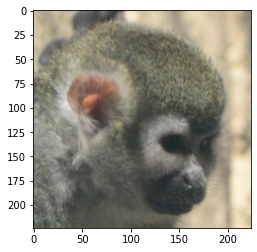

In [14]:
show_first_image(train_ds)

### Pre-Process Data for VGG

In [15]:
preprocessed_train_ds = train_ds.map(lambda x, y: (vgg16.preprocess_input(x), y))
preprocessed_val_ds = val_ds.map(lambda x, y: (vgg16.preprocess_input(x), y))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


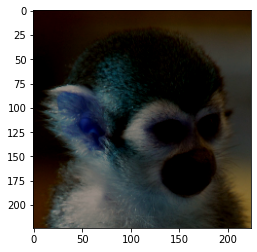

In [16]:
show_first_image(preprocessed_train_ds)

### Model Architecture

In [17]:
# See here for implementation https://keras.io/api/applications/vgg/#vgg16-function
vgg_model = vgg16.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS),
    pooling='avg',  # Global average pooling applied.
)
# Freeze all layers
vgg_model.trainable = False
fully_connected_output = Sequential()

# Add dense layers to perform prediction
fully_connected_output.add(Flatten())
fully_connected_output.add(Dense(units=4096, activation="relu"))
fully_connected_output.add(Dense(units=4096, activation="relu"))
fully_connected_output.add(Dense(units=number_classes, activation="softmax"))

# Create final model
model = Sequential([vgg_model, fully_connected_output])

### Compile Model

In [18]:
optimizer = adam_v2.Adam(learning_rate=LEARNING_RATE)
print("Learning rate:", LEARNING_RATE)

# sparse as Y values are stored as integers (0-42), rather than one-hot encoded (i.e. 3 class, [1,0,0], [0,1,0], [0,0,1])
loss = sparse_categorical_crossentropy

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

Learning rate: 0.001


### Train Model

In [19]:
hist = model.fit(
    x=preprocessed_train_ds,  # y is obtained from this x
    epochs=NUM_EPOCHS,
    verbose=True,
    validation_data=preprocessed_val_ds)

Epoch 1/20
7/7 [==============================] - 17s 2s/step - loss: 22.8376 - accuracy: 0.0594 - val_loss: 13.7521 - val_accuracy: 0.0600
Epoch 2/20
7/7 [==============================] - 17s 2s/step - loss: 5.4454 - accuracy: 0.2376 - val_loss: 2.9490 - val_accuracy: 0.3800

### Plot Results

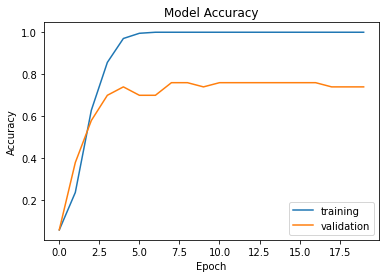

In [20]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["training", "validation"])
plt.show()

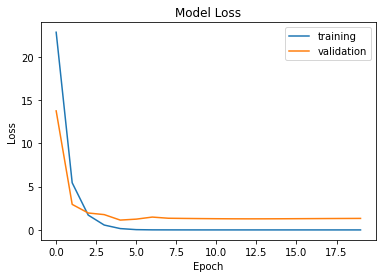

In [21]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["training", "validation"])
plt.show()